## Machine Learning Project  - Image Captioning ##

### Submitted By - Anargha Ajoykumar ##

In [1]:
# Importing required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

### Importing Data ###

In [2]:
#Setting the directory
base_dir    = 'kaggle'
image_path1  = 'kaggle/Images'

In [3]:
#Importing caption data and image data
caption = pd.read_csv('kaggle/captions.txt')
caption.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


### EDA ###

In [4]:
# Displaying images with captions

#Import required library
from textwrap import wrap

#Defining function to call image
def load_image(path):
    img = load_img(path, color_mode='rgb', target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    return img

#Defining function to display image
def display_image(df):
    df = df.reset_index(drop = True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        
        n+=1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = load_image(f"kaggle/Images/{df.image[i]}")
        
        plt.imshow(image)
        plt.title("\n".join(wrap(df.caption[i], 20)))
        plt.axis('off')

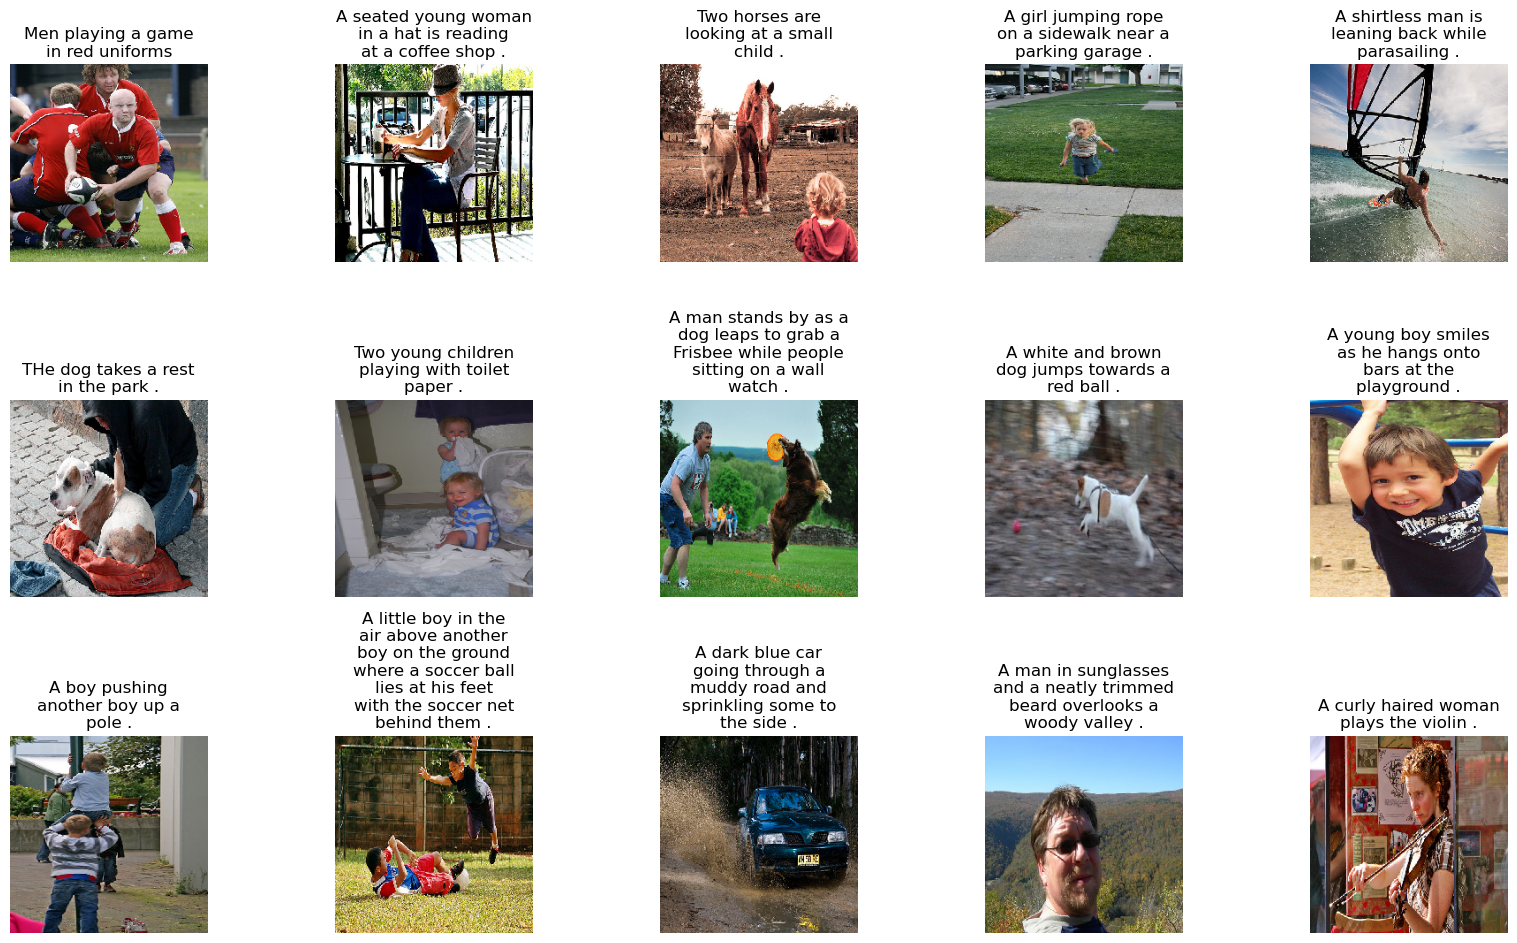

In [5]:
display_image(caption.sample(15))

**The captions respective to the image is provided above each image.**

In [6]:
#To count the number of pictures
unique_counts = caption['image'].nunique()
print('The number of images in the dataset: ',unique_counts)

The number of images in the dataset:  8091


In [7]:
#To count the number of captions in the data
unique_captions = caption['caption'].nunique()
print('The number of captions in the dataset: ',unique_captions)

The number of captions in the dataset:  40201


In [8]:
#To count how many captions are provided for each image
caption_count_image = caption['image'].value_counts()
print('The count of captions for each image is : ',caption_count_image.unique()[0])

The count of captions for each image is :  5


In [9]:
#To find out the length of the caption

#Importing required package
import string

#defining characters to be removed
chars_to_remove   = string.punctuation
translation_table = str.maketrans("", "", chars_to_remove)

#adding column caption_length to the caption df
caption['caption_length'] = [len(c.translate(translation_table).split()) for c in caption['caption']]
caption.head()

,image,caption,caption_length
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,17
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,7
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,8
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,9
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,12


The df above shows the length of each caption.

/Users/roopeshraveendran/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


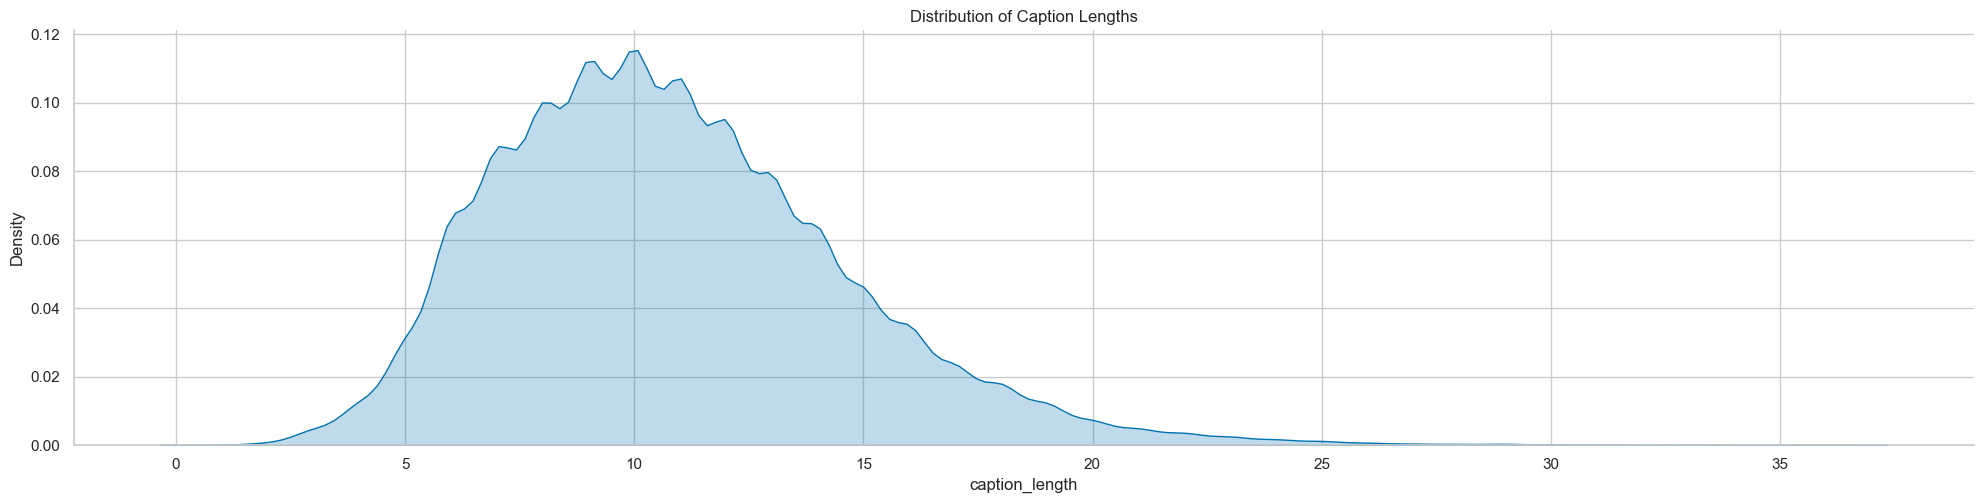

In [10]:
#Plotting the caption length
sns.set_theme(style = "whitegrid")
sns.set_palette("colorblind")

plot = sns.displot(data = caption, x = 'caption_length', kind = 'kde', fill = True, aspect = 4)

# title
plot.set(title = 'Distribution of Caption Lengths')

# Show the plot
plt.show()

The number of words in most caption lies between 6-14.

In [11]:
#finding the most used word
from collections import Counter

#Defining function to find the most used word
all_words = ' '.join(caption['caption'])
words     = all_words.translate(translation_table).lower().split()
count     = Counter(words)
top_words = count.most_common(20)
top_words

[('a', 62986),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265),
 ('of', 6713),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3173),
 ('wearing', 3062),
 ('at', 2914)]

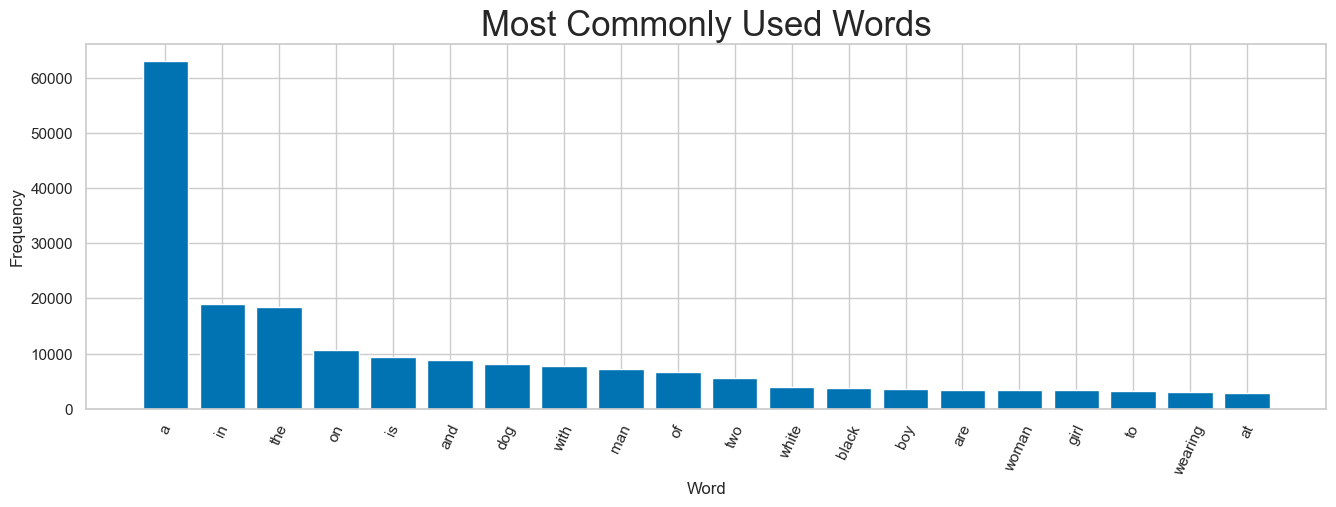

In [12]:
#Plotting most used words
#most_words = most_used('caption',50)
sns.set_palette("colorblind")

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=65)
plt.subplots_adjust(bottom=0.15)
plt.show()

### Extracting Image features ###

In [13]:
#Defining model
model = VGG16()

#restructure the model to remove 2 output layers
model = Model(model.input, model.layers[-2].output)

# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
#Importing image
features  = {}
directory = os.path.join(base_dir, 'Images')

# Get a list of image files in the folder
image_files = [file for file in os.listdir(directory) if file.endswith(('.jpg', '.png', '.jpeg'))]

# Initialize tqdm with the list of image files
for image_file in tqdm(image_files, desc = "Importing Images", unit = "image"):
    # Construct the full path to the image
    image_path = os.path.join(directory, image_file)
    
    # Read the image using Keras's load_img
    img_load = load_img(image_path, color_mode = 'rgb', target_size=(224, 224))
    
    #converting image to array
    img  = img_to_array(img_load)
    
    #Converting to required shape by the model
    img = img.reshape((1, 224, 224, 3))
    
    # preprocess
    img = preprocess_input(img)
    
    # extract features
    feature = model.predict(img, verbose=0)
    
    # get image ID
    id = image_file.split('.')[0]
    
    # store feature
    features[id] = feature

Importing Images:   0%|          | 0/8091 [00:00<?, ?image/s]

In [15]:
#Defining path to store pickle
pickle_file_path = os.path.join(base_dir, 'features.pkl')

# Store features in pickle file
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(features, pickle_file)
    

In [16]:
# Load features from pickle file
with open(pickle_file_path, 'rb') as pickle_file:
    features = pickle.load(pickle_file)

### Load the captions data ###

In [17]:
#Define the captions file path
caption_file_path = os.path.join(base_dir, 'captions.txt')

# Read the contents of the text file
with open(caption_file_path, 'r') as cap_file:
    next(cap_file)
    captions_doc = cap_file.read()

In [18]:
#Displaying one line of data in text file
captions_doc.split('\n')[0]

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .'

In [19]:
#Defining a dictionary to append image_id and caption
image_caption ={}

for line in tqdm(captions_doc.split('\n')):
    
    #Split the line by comma
    l = line.split(',')
    
    #Below code deals with only image_id and caption. Removing other scenarios like just image_id exists
    if len(l) < 2:
        continue
    
    #Getting image_id and caption seperately
    image_id, caption = l[0],l[1:]
    
    #remove .jpg extension from image id
    image_id = image_id[:image_id.index('.')]
    
    #converting list to string for caption
    caption = " ".join(caption)
    
    if image_id not in image_caption:
        image_caption[image_id] = []
    # store the caption
    image_caption[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [20]:
# Verifying if all entries are added to image_caption
len(image_caption)

8091

### Pre-processing the caption text ###

In [21]:
#Cleaning the txt data in captions

for number, captions in image_caption.items():
    for i in range(len(captions)):
        caption = captions[i]
        caption = caption.lower().replace('[^A-Za-z]', '').replace('\s+', ' ')
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
        captions[i] = caption
    

In [22]:
#Displaying the cleaned text for captions
next(iter(image_caption.items()))

('1000268201_693b08cb0e',
 ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'])

In [23]:
#Loading all captions
captions_combined = []
for id in image_caption:
    for sentence in image_caption[id]:
        captions_combined.append(sentence)
        
#Displaying the list loaded with captions
captions_combined[0:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [24]:
# Tokenize the text for decoding later

# Create a tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the text
tokenizer.fit_on_texts(captions_combined)

# Get the word index
word_index = tokenizer.word_index

#Finding size of the words
vocab_size = len(word_index) + 1

print(vocab_size)

8485


In [25]:
#Maximum length of caption(For padding purpose)
max_length = 1
for i in captions_combined:
    if (len(i.split()) >= max_length):
        max_length = len(i.split())

max_length

35

### Train - Test Split ###

In [26]:
#Splitting to train and test
image_ids = list(image_caption.keys())
splitting_point = int(len(image_ids) * 0.9)
train = image_ids[:splitting_point]
test = image_ids[splitting_point:]
print('The size of train data set: ',len(train))

The size of train data set:  7281


In [27]:
print('The size of test data set: ',len(test))

The size of test data set:  810


#### Custom defining the data generator ####

In [28]:
def data_generator(data_keys, image_caption, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = image_caption[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### Model Creation ###

A subtle modification has been applied to the initial model architecture to enhance its performance. The image feature embeddings are now integrated into the output of the LSTMs before being forwarded to the fully connected layers.

In [29]:
#Encoder model

#image feature layer
encoder_input1 = Input(shape = (4096,)) #FC2 dense layer of VGG16 is 4096
feature_layer1 = Dropout(0.4)(encoder_input1)
feature_layer2 = Dense(256, activation = 'relu')(feature_layer1)

#sequence feature layer
encoder_input2 = Input(shape = (max_length,))
sequence_layer1 = Embedding(vocab_size, 256, mask_zero=True)(encoder_input2)
sequence_layer2 = Dropout(0.4)(sequence_layer1)
sequence_layer3 = LSTM(256)(sequence_layer2)

In [30]:
#Decoder model

decoder1 = add([feature_layer2, sequence_layer3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
decoder_output = Dense(vocab_size, activation = 'softmax')(decoder2)


In [31]:
#Combining both models
model = Model(inputs = [encoder_input1, encoder_input2], outputs = decoder_output)

#Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

#Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2172160   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                            

In [32]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, image_caption, features, tokenizer, max_length, vocab_size, batch_size)
    
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 139s 613ms/step - loss: 2.2002


In [33]:
# save the model
model.save(base_dir + '/best_model.h5')

/Users/roopeshraveendran/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Generating captions from images ###

In [34]:
#Creating function that inputs index and returns word
def generate_word(integer, tokenizer):
    return next((word for word, index in word_index.items() if integer == index), None)

In [35]:
# generate caption for an image
def generate_caption(model, image, tokenizer, max_length):
    input_text = 'startseq'
    
    # iterate over the max length of sequence
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        word_index = np.argmax(yhat)
        word = generate_word(word_index, tokenizer)

        if word is None:
            break
        
        input_text += " " + word
        if word == 'endseq':
            break
      
    return input_text

In [36]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu_scores(model, test_data, image_caption, tokenizer, max_length):
    actual, predicted = list(), list()

    for key in tqdm(test_data):
        captions = image_caption[key]
        y_pred = generate_caption(model, features[key], tokenizer, max_length) 
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()

        actual.append(actual_captions)
        predicted.append(y_pred)

    # Calculate BLEU scores
    bleu_1_score = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2_score = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

    print("BLEU-1: {:.4f}".format(bleu_1_score))
    print("BLEU-2: {:.4f}".format(bleu_2_score))

evaluate_bleu_scores(model, test, image_caption, tokenizer, max_length)    

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.5305
BLEU-2: 0.3012


BLEU (Bilingual Evaluation Understudy) is a metric used for evaluating the quality of machine-generated text, particularly in the context of machine translation. BLEU scores range from 0 to 1, where a higher score indicates better similarity between the generated and reference text. The BLEU Score of .53 is considered to be a good score in the context of text generation.

### Visualizing the Result ###

In [37]:
from PIL import Image

def display_caption(image_name):
    
    image_id = image_name.split('.')[0]
    image_path = os.path.join(directory, image_name)
    image = Image.open(image_path)
    plt.figure(1)
    plt.subplot(111)
    plt.imshow(image)
    captions = image_caption[image_id]
    print('Actual')
    print('------------------------')
    
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = generate_caption(model, features[image_id], tokenizer, max_length)
    print('Predicted')
    print('------------------------')
    print(y_pred)
    

Actual
------------------------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
Predicted
------------------------
startseq man and dog are sitting on bench endseq


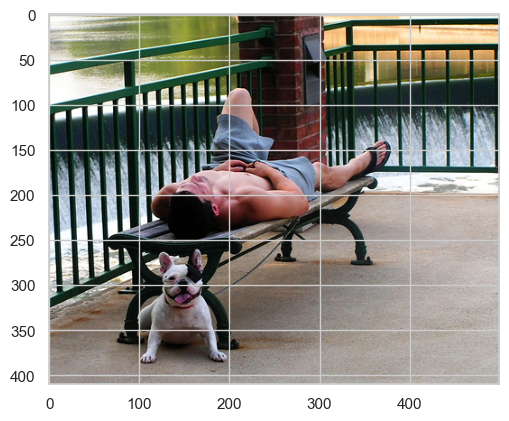

In [38]:
#Testing with image name
display_caption("1003163366_44323f5815.jpg")

Actual
------------------------
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq
Predicted
------------------------
startseq two dogs run through the snow endseq


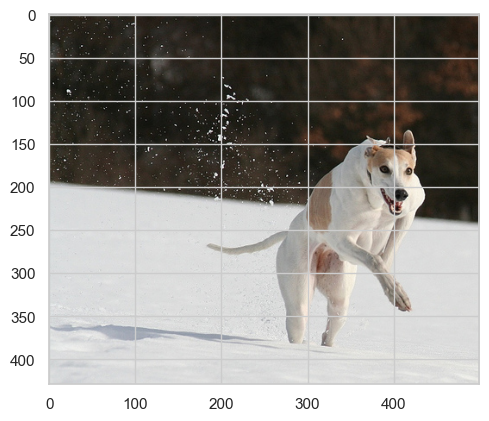

In [39]:
#Testing with image name
display_caption("101654506_8eb26cfb60.jpg")

### Testing with unseen image ###

'startseq person in black hat is racing on the ground endseq'

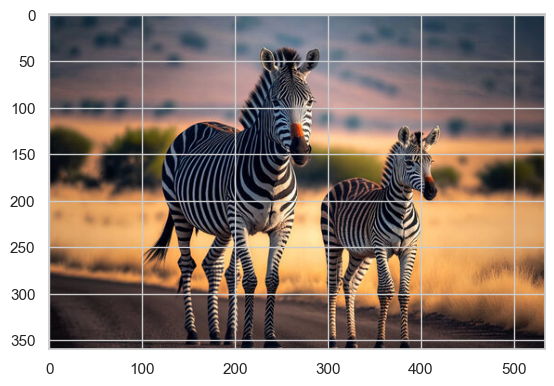

In [43]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

image_path = 'kaggle/pic_1.jpg'

#Plot the image
image = Image.open(image_path)
plt.figure(1)
plt.subplot(111)
plt.imshow(image)
    
image = load_img(image_path, target_size=(224, 224))

image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image, verbose=0)

generate_caption(model, feature, tokenizer, max_length)